# Model Training

In this notebook we will train different models to predict the target variable `class`.

First we will load the data, split it into training and testing sets and balance the training set.

Then we will train the following models:

Simple models:

- Decision tree classifier
- Logistic regression
- K-nearest neighbors classifier
- Multilayer perceptron classifier

Ensemble models:

- Random forest classifier
- Gradient boosting classifier
- XGBoost

The models will be evaluated through:

- Accuracy
- ROC AUC
- F1 score
- Recall on poisonous class

The best 3 models will be selected and their hyperparameters will be optimized using randomized search and a genetic algorithm.

Finally, we will save the best model and its hyperparameters and use it for deployment.

In [41]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import friedmanchisquare
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

sns.set_style("darkgrid")
sns.set_palette("Set1")

In [2]:
df = pd.read_csv("../Data/WorkingData/train.csv")

In [3]:
filename = "../Models/Transformations/transformations.pkl"
minmax, labelEncoder = pickle.load(open(filename, "rb"))

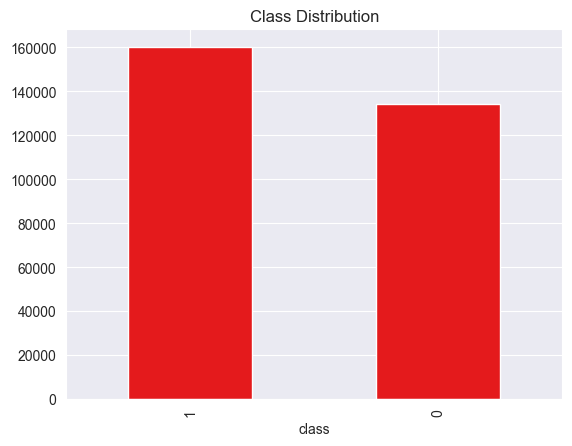

In [4]:
X = df.drop(columns=["class"])
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=13)
y_train.value_counts().plot(kind="bar", title="Class Distribution")
plt.show()

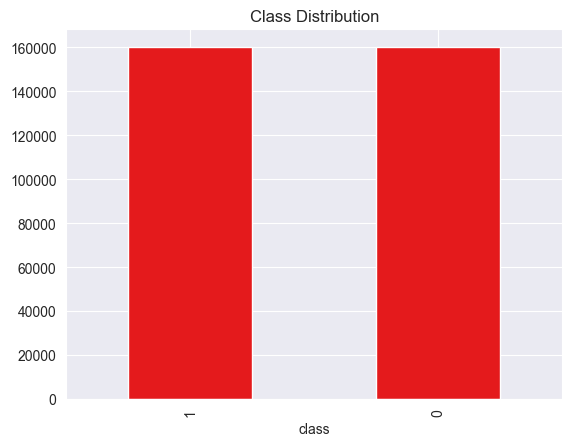

In [5]:
smote = SMOTE(sampling_strategy="auto", random_state=13)
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts().plot(kind="bar", title="Class Distribution")
plt.show()

In [6]:
all_models = pd.DataFrame(index=["Accuracy", "ROC AUC", "F1 Score", "Recall Poisonous"])

### Decision Tree Classifier

In [7]:
model_dt = DecisionTreeClassifier(criterion="gini", min_samples_leaf=20, max_depth=5)
model_dt.fit(X_train, y_train)

Y_pred = model_dt.predict(X_test)
print(
    metrics.classification_report(
        y_true=y_test, y_pred=Y_pred, target_names=labelEncoder.classes_
    )
)

all_models["Decision Tree"] = [
    metrics.accuracy_score(y_test, Y_pred),
    metrics.roc_auc_score(y_test, Y_pred),
    metrics.f1_score(y_test, Y_pred),
    metrics.recall_score(y_test, Y_pred, pos_label=1),
]

              precision    recall  f1-score   support

           e       0.72      0.70      0.71     57394
           p       0.76      0.78      0.77     68606

    accuracy                           0.74    126000
   macro avg       0.74      0.74      0.74    126000
weighted avg       0.74      0.74      0.74    126000



### Logistic Regression

In [8]:
model_lr = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=500,
    random_state=42,
)
model_lr.fit(X_train, y_train)

Y_pred = model_lr.predict(X_test)
Y_pred_proba = model_lr.predict_proba(X_test)[:, 1]

print(
    metrics.classification_report(
        y_true=y_test, y_pred=Y_pred, target_names=labelEncoder.classes_
    )
)

all_models["Logistic Regression"] = [
    metrics.accuracy_score(y_test, Y_pred),
    metrics.roc_auc_score(y_test, Y_pred_proba),
    metrics.f1_score(y_test, Y_pred),
    metrics.recall_score(y_test, Y_pred, pos_label=1),
]

              precision    recall  f1-score   support

           e       0.71      0.79      0.75     57394
           p       0.81      0.73      0.76     68606

    accuracy                           0.76    126000
   macro avg       0.76      0.76      0.76    126000
weighted avg       0.76      0.76      0.76    126000



### K-Nearest Neighbors Classifier

In [9]:
model_knn = KNeighborsClassifier(n_neighbors=2, metric="euclidean")
model_knn.fit(X_train, y_train)

Y_pred = model_knn.predict(X_test)
print(
    metrics.classification_report(
        y_true=y_test, y_pred=Y_pred, target_names=labelEncoder.classes_
    )
)

all_models["KNN"] = [
    metrics.accuracy_score(y_test, Y_pred),
    metrics.roc_auc_score(y_test, Y_pred),
    metrics.f1_score(y_test, Y_pred),
    metrics.recall_score(y_test, Y_pred, pos_label=1),
]

              precision    recall  f1-score   support

           e       0.96      0.99      0.98     57394
           p       0.99      0.97      0.98     68606

    accuracy                           0.98    126000
   macro avg       0.98      0.98      0.98    126000
weighted avg       0.98      0.98      0.98    126000



### Multilayer Perceptron Classifier

In [10]:
model_rn = MLPClassifier(
    activation="relu",
    hidden_layer_sizes=(25),
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=0.02,
    momentum=0.3,
    max_iter=500,
    verbose=False,
)
model_rn.fit(X_train, y_train)

Y_pred = model_rn.predict(X_test)
print(
    metrics.classification_report(
        y_true=y_test, y_pred=Y_pred, target_names=labelEncoder.classes_
    )
)

all_models["NN"] = [
    metrics.accuracy_score(y_test, Y_pred),
    metrics.roc_auc_score(y_test, Y_pred),
    metrics.f1_score(y_test, Y_pred),
    metrics.recall_score(y_test, Y_pred, pos_label=1),
]

              precision    recall  f1-score   support

           e       0.98      0.98      0.98     57394
           p       0.99      0.98      0.98     68606

    accuracy                           0.98    126000
   macro avg       0.98      0.98      0.98    126000
weighted avg       0.98      0.98      0.98    126000



### Gradient Boosting Classifier

In [11]:
model_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
)
model_gb.fit(X_train, y_train)

Y_pred = model_gb.predict(X_test)
Y_pred_proba = model_gb.predict_proba(X_test)[:, 1]

print(
    metrics.classification_report(
        y_true=y_test, y_pred=Y_pred, target_names=labelEncoder.classes_
    )
)

all_models["Gradient Boosting"] = [
    metrics.accuracy_score(y_test, Y_pred),
    metrics.roc_auc_score(y_test, Y_pred_proba),
    metrics.f1_score(y_test, Y_pred),
    metrics.recall_score(y_test, Y_pred, pos_label=1),
]

              precision    recall  f1-score   support

           e       0.91      0.94      0.93     57394
           p       0.95      0.93      0.94     68606

    accuracy                           0.93    126000
   macro avg       0.93      0.93      0.93    126000
weighted avg       0.93      0.93      0.93    126000



### Random Forest Classifier

In [12]:
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)
model_rf.fit(X_train, y_train)

Y_pred = model_rf.predict(X_test)
Y_pred_proba = model_rf.predict_proba(X_test)[:, 1]

print(
    metrics.classification_report(
        y_true=y_test, y_pred=Y_pred, target_names=labelEncoder.classes_
    )
)

all_models["Random Forest"] = [
    metrics.accuracy_score(y_test, Y_pred),
    metrics.roc_auc_score(y_test, Y_pred_proba),
    metrics.f1_score(y_test, Y_pred),
    metrics.recall_score(y_test, Y_pred, pos_label=1),
]

              precision    recall  f1-score   support

           e       0.96      0.97      0.96     57394
           p       0.97      0.97      0.97     68606

    accuracy                           0.97    126000
   macro avg       0.97      0.97      0.97    126000
weighted avg       0.97      0.97      0.97    126000



### XGBoost

In [13]:
model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
)
model_xgb.fit(X_train, y_train)

Y_pred = model_xgb.predict(X_test)
Y_pred_proba = model_xgb.predict_proba(X_test)[:, 1]

print(
    metrics.classification_report(
        y_true=y_test, y_pred=Y_pred, target_names=labelEncoder.classes_
    )
)

all_models["XGBoost"] = [
    metrics.accuracy_score(y_test, Y_pred),
    metrics.roc_auc_score(y_test, Y_pred_proba),
    metrics.f1_score(y_test, Y_pred),
    metrics.recall_score(y_test, Y_pred, pos_label=1),
]

              precision    recall  f1-score   support

           e       0.97      0.98      0.98     57394
           p       0.98      0.98      0.98     68606

    accuracy                           0.98    126000
   macro avg       0.98      0.98      0.98    126000
weighted avg       0.98      0.98      0.98    126000



### All models evaluation results

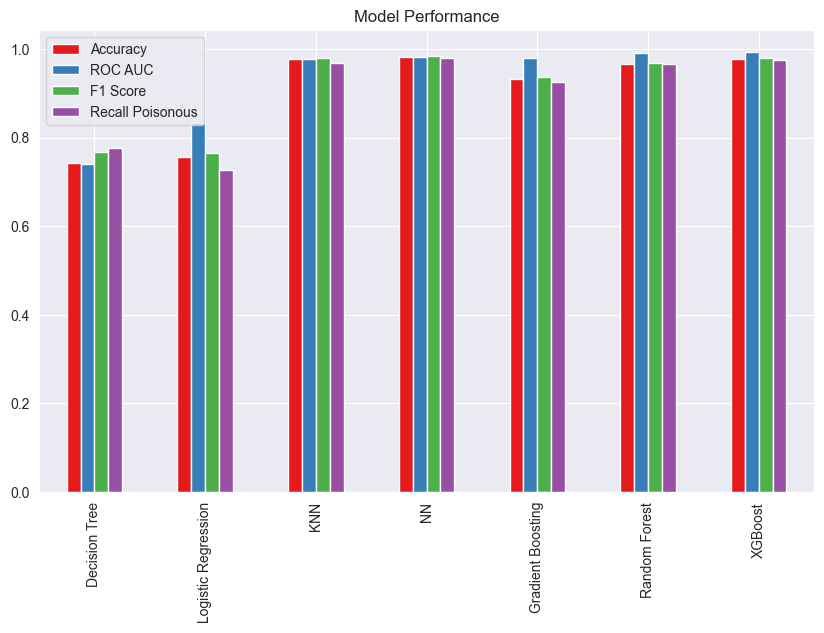

In [15]:
all_models.T.plot(kind="bar", figsize=(10, 6), title="Model Performance")
plt.show()

In [16]:
all_models

,Decision Tree,Logistic Regression,KNN,NN,Gradient Boosting,Random Forest,XGBoost
Accuracy,0.743262,0.755524,0.976960,0.981770,0.931913,0.965659,0.978444
ROC AUC,0.740089,0.832845,0.977913,0.981937,0.978634,0.990727,0.993085
F1 Score,0.766923,0.764062,0.978594,0.983206,0.936755,0.968383,0.980126
Recall Poisonous,0.775748,0.727021,0.967204,0.980060,0.926071,0.965878,0.976168


### Hypothesis testing for best models

To find the best models we will perform a hypothesis test using the Friedman test and the Nemenyi post-hoc test.

[Friedman Test](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-11/issue-1/A-Comparison-of-Alternative-Tests-of-Significance-for-the-Problem/10.1214/aoms/1177731944.full) is a non-parametric test that will allow us to compare the models using the 4 metrics we used for evaluation, as a group, doing something similar to what ANOVA does but in a multivariate way.

[Nemenyi Post-Hoc Test](https://catalog.princeton.edu/catalog/9920813653506421) is a distribution free, non-parametric test that will allow us to compare the models in pairs.

If there is a significant difference between the models as a group, we will test for differences between the models in pairs using the Nemenyi test. The end result is a table that compares Nemenyi's p-values for each pair of models. If the p-value is less than 0.05, we can say that the models are significantly different.

In [34]:
models = all_models.columns.to_list()

decision_tree_scores = np.array([0.743262, 0.740089, 0.766923, 0.775748])
logistic_regression_scores = np.array([0.755524, 0.832845, 0.764062, 0.727021])
knn_scores = np.array([0.981770, 0.977913, 0.978594, 0.967204])
nn_scores = np.array([0.981770, 0.981937, 0.983206, 0.980060])
gradient_boosting_scores = np.array([0.931913, 0.978634, 0.936755, 0.926071])
random_forest_scores = np.array([0.965659, 0.990727, 0.968383, 0.965878])
xgboost_scores = np.array([0.978444, 0.993085, 0.980126, 0.976168])

# Friedman test
stat, p = friedmanchisquare(
    decision_tree_scores,
    logistic_regression_scores,
    knn_scores,
    nn_scores,
    gradient_boosting_scores,
    random_forest_scores,
    xgboost_scores,
)
print(f"Friedman test statistic: {stat}, p-value: {p}")

# If p < 0.05, we reject the null hypothesis
if p < 0.05:
    print("There is a significant difference between the models")
    # Nemenyi post-hoc test for individual comparisons
    scores_matrix = np.array(
        [
            decision_tree_scores,
            logistic_regression_scores,
            knn_scores,
            nn_scores,
            gradient_boosting_scores,
            random_forest_scores,
            xgboost_scores,
        ]
    ).T
    posthoc = sp.posthoc_nemenyi_friedman(scores_matrix)
    print(posthoc)
else:
    print("There is no significant difference between the models")

Friedman test statistic: 20.421524663677125, p-value: 0.0023291872761883672
There is a significant difference between the models
          0         1         2         3         4         5         6
0  1.000000  1.000000  0.290208  0.023915  0.913892  0.437865  0.050343
1  1.000000  1.000000  0.290208  0.023915  0.913892  0.437865  0.050343
2  0.290208  0.290208  1.000000  0.958006  0.938582  0.999982  0.990331
3  0.023915  0.023915  0.958006  1.000000  0.385602  0.883669  0.999982
4  0.913892  0.913892  0.938582  0.385602  1.000000  0.983178  0.547804
5  0.437865  0.437865  0.999982  0.883669  0.983178  1.000000  0.958006
6  0.050343  0.050343  0.990331  0.999982  0.547804  0.958006  1.000000


In [33]:
posthoc_df = pd.DataFrame(posthoc)
posthoc_df.columns = models
posthoc_df.index = models
posthoc_df

,Decision Tree,Logistic Regression,KNN,NN,Gradient Boosting,Random Forest,XGBoost
Decision Tree,1.000000,1.000000,0.290208,0.023915,0.913892,0.437865,0.050343
Logistic Regression,1.000000,1.000000,0.290208,0.023915,0.913892,0.437865,0.050343
KNN,0.290208,0.290208,1.000000,0.958006,0.938582,0.999982,0.990331
NN,0.023915,0.023915,0.958006,1.000000,0.385602,0.883669,0.999982
Gradient Boosting,0.913892,0.913892,0.938582,0.385602,1.000000,0.983178,0.547804
Random Forest,0.437865,0.437865,0.999982,0.883669,0.983178,1.000000,0.958006
XGBoost,0.050343,0.050343,0.990331,0.999982,0.547804,0.958006,1.000000


### Hipothesis testing conclusion

According to the Nemenyi test, the best models are:

1. Neural Network
2. XGBoost

Additionally, the Random Forest and KNN models are also a good choices.

Taking into account that Random Forest was faster to train than KNN, we will choose it to complete the trio for hyperparameter optimization.

## Hiperparameter optimization

After hipothesis testing, we will optimize the hyperparameters of:

1. Neural Network
2. XGBoost
3. Random Forest

We will use RandomizedSearch to determine some hyperparameters and Bayesian Optimization and Genetic Algorithm to determine the others.

### Data Saving for Hiperparametrization

In [44]:
filename = "../Models/Parametrization/parametrization.pkl"
pickle.dump([X_train, X_test, y_train, y_test], open(filename, "wb"))